In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()


# Montage de Google Drive pour accéder aux fichiers nécessaires depuis Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Chargement du fichier texte contenant des CV et offres découpés en phrases simples, en ignorant les lignes vides

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/final/data_cv_offre.txt'

# Lire chaque ligne comme une phrase et ignorer les lignes vides
with open(file_path, 'r', encoding='utf-8') as f:
    phrases = [line.strip() for line in f if line.strip()]

# Créer le DataFrame

data= phrases

print(len(data))




631699


# Supprimer le mot non renseigné depuis toute les lignes

In [ ]:
#les valeurs manquantes
import re

data = [
    phrase for phrase in data
    if not re.fullmatch(r"non renseign[eé]\.?", phrase.strip(), flags=re.IGNORECASE)
]

print(data[0:20])

print(len(data))


['Types de métiers recherchés', 'Informatique', 'nouvelles technologies', 'Expérience professionnelle', 'Expérience dans les secteurs d´activité suivants :', 'Informatique, SSII, Internet', 'Expérience professionnelle', 'Compétences', 'DÉVELOPPEMENT WEB, NOTAMMENT AVEC SPRING BOOT ET REACTJS', 'Formation', "Niveau d'études :", 'Bac+5 et plus', 'GENIE LOGICIEL/MIAGE', 'HIGHTECH', 'Depuis 10.2024', 'Compétences clés', 'development web', 'SpringBoot', 'JAVASCRIPT', 'REACT']
628412


# Assuere de Preparer une liste des phrases: (des phrase a partir la liste des CV + des phrases appartir la liste des offres)

In [ ]:
import random

# 1. Sélectionner 100 000 phrases aléatoires parmi data[0:626037]
part1 = random.sample(data[0:623000], 150000)


# 2. Prendre les 5 662 phrases fixes à partir de l’indice 626037
part2 = data[623411:628412]

# 3. Fusionner les deux listes
subset = part1 + part2
print(len(part1))

print(len(part2))
print(len(subset))


150000
5001
155001


# Fine-tuning non supervisé de CamemBERT avec Denoising AutoEncoder (TSDaE) sur un corpus de phrases françaises — entraînement sur 2 époques

In [ ]:
from sentence_transformers import SentenceTransformer, models, datasets, losses
from torch.utils.data import DataLoader
import nltk

# nltk ne propose pas 'punkt_tab', il faut 'punkt' pour tokenizer les phrases
nltk.download('punkt_tab')
# Charger CamemBERT au lieu de bert-base-uncased
model_name = "camembert-base"

# Transformer + pooling (CLS pooling comme dans ton code)
word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_cls_token=True,  # CLS pooling
    pooling_mode_mean_tokens=False,
    pooling_mode_max_tokens=False
)

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# Exemple : ta liste de phrases en français
sentences = subset  # Assure-toi que data est une liste de phrases en français

# Créer le dataset Denoising AutoEncoder pour l'entraînement non supervisé
train_dataset = datasets.DenoisingAutoEncoderDataset(sentences)

# DataLoader pour batcher les données
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Loss Denoising AutoEncoder avec CamemBERT comme encodeur et décodeur
train_loss = losses.DenoisingAutoEncoderLoss(
    model,
    decoder_name_or_path=model_name,
    tie_encoder_decoder=True
)

# Pour la compatibilité avec fit_mixin et HuggingFace datasets (ton code)
import sentence_transformers.fit_mixin as fm
from datasets import Dataset, DatasetDict
fm.Dataset = Dataset
fm.DatasetDict = DatasetDict

# Lancement du fine-tuning
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=2,
    weight_decay=0,
    scheduler="constantlr",
    optimizer_params={"lr": 3e-5},
    show_progress_bar=True,
)

# Sauvegarder le modèle fine-tuné
model.save("drive/MyDrive/camembert/tsdae-camemebert-2")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
Some weights of CamembertForCausalLM were not initialized from the model checkpoint at camembert-base and are newly initialized: ['roberta.encoder.layer.0.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.0.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.0.crossattention.output.dense.bias', 'roberta.encoder.layer.0.crossattention.output.dense.weight', 'roberta.encoder.layer.0.crossattention.self.key.bias', 'roberta.encoder.layer.0.crossattention.self.key.weight', 'roberta.encoder.layer.0.crossattention.self.query.bias', 'roberta.encoder.layer.0.crossattention.self.query.weight', 'roberta.encoder.layer.0.crossattention.self.value.bias', 'roberta.encoder.layer.0.crossattention.self.value.weight', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.weight', 'roberta.encoder.la

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,4.412900
1000,3.082900
1500,2.826700
2000,2.588000
2500,2.448300
3000,2.386300
3500,2.346400
4000,2.216000
4500,2.224900
5000,2.129600


# entraînement sur 3 époques

In [ ]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=3,
    weight_decay=0,
    scheduler="constantlr",
    optimizer_params={"lr": 3e-5},
    show_progress_bar=True,
)
model.save("drive/MyDrive/camembert/tsdae-camemebert-3")


Step,Training Loss
500,1.581700
1000,1.620000
1500,1.583200
2000,1.646800
2500,1.626500
3000,1.624000
3500,1.640900
4000,1.603300
4500,1.590800
5000,1.510200


# entraînement sur 4 époques

In [ ]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=4,
    weight_decay=0,
    scheduler="constantlr",
    optimizer_params={"lr": 3e-5},
    show_progress_bar=True,
)
model.save("drive/MyDrive/camembert/tsdae-camemebert-4")


Step,Training Loss
500,0.609700
1000,0.623300
1500,0.636900
2000,0.647600


Step,Training Loss
500,0.609700
1000,0.623300
1500,0.636900
2000,0.647600
2500,0.652300
3000,0.646000
3500,0.653300
4000,0.668500
4500,0.674300
5000,0.619500


# entraînement sur 5 époques

In [ ]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=5,
    weight_decay=0,
    scheduler="constantlr",
    optimizer_params={"lr": 3e-5},
    show_progress_bar=True,
)
model.save("drive/MyDrive/camembert/tsdae-camemebert-5")


Step,Training Loss
500,0.342500
1000,0.349900
1500,0.362600
2000,0.369100
2500,0.371400


Step,Training Loss
500,0.342500
1000,0.349900
1500,0.362600
2000,0.369100
2500,0.371400
3000,0.369800
3500,0.369900
4000,0.379900
4500,0.385800
5000,0.367500


# entraînement sur 6 époques

In [ ]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=6,
    weight_decay=0,
    scheduler="constantlr",
    optimizer_params={"lr": 3e-5},
    show_progress_bar=True,
)
model.save("drive/MyDrive/camembert/tsdae-camemebert-6")


Step,Training Loss
500,0.374000
1000,0.368300
1500,0.378100


KeyboardInterrupt: 

# *Utiliser le model camembert avec 4 epoch pour crée des paire (cv-offre)*

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Chargement une autre liste des cv et utilsier la meme liste ds offres

In [2]:
import pandas as pd


df_offre = pd.read_csv("drive/MyDrive/french_offre.csv")
df_cv    = pd.read_csv("drive/MyDrive/cv_nv.csv")

data_offre = pd.DataFrame(df_offre)

data_cv = pd.DataFrame(df_cv)

print(data_offre.columns.tolist())

print(data_cv.columns.tolist())
print(f"nombre des ligne de dataset cv_nv : {data_cv.shape[0]}")
print(f"nombre des ligne de dataset data_offre : {data_offre.shape[0]}")

['Unnamed: 0', 'adresseOffre', 'intitule', 'datePublication', 'datePremierePublication', 'LANGUE', 'SAVOIR_ETRE', 'SAVOIR_FAIRE', 'salaireTexte', 'entreprise', 'enseigne', 'description', 'profil', 'entreprise_description']
['Types de métiers recherchés', 'Expérience professionnelle', 'Compétences', 'Formation', 'Compétences clés', 'Langues', 'Disponibilité :', 'Mobilité géographique :', 'Lieu de résidence :', 'Types de contrats acceptés :']
nombre des ligne de dataset cv_nv : 2105
nombre des ligne de dataset data_offre : 403


In [3]:
data_offre = data_offre[['adresseOffre', 'intitule', 'LANGUE', 'SAVOIR_ETRE', 'SAVOIR_FAIRE', 'salaireTexte', 'description', 'profil']]


print(data_offre.isnull().sum())
print("---------" + "\n")
print(data_cv.isnull().sum())

adresseOffre     62
intitule          0
LANGUE          244
SAVOIR_ETRE      63
SAVOIR_FAIRE      9
salaireTexte      0
description       0
profil            0
dtype: int64
---------

Types de métiers recherchés       0
Expérience professionnelle        0
Compétences                       3
Formation                         0
Compétences clés                388
Langues                           0
Disponibilité :                   0
Mobilité géographique :           0
Lieu de résidence :               0
Types de contrats acceptés :      0
dtype: int64


In [4]:
import re

# Nettoyer les colonnes  (retirer les emojis, ponctuation et symboles inutiles)
data_offre['adresseOffre'] = data_offre['adresseOffre'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
data_offre['intitule'] = data_offre['intitule'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
data_offre['SAVOIR_ETRE'] = data_offre['SAVOIR_ETRE'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
data_offre['SAVOIR_FAIRE'] = data_offre['SAVOIR_FAIRE'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
data_offre['salaireTexte'] = data_offre['salaireTexte'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
data_offre['profil'] = data_offre['profil'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))

In [5]:
import re

# Nettoyer les colonnes  (retirer les emojis, ponctuation et symboles inutiles)
data_cv['Compétences'] = data_cv['Compétences'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
data_cv['Compétences clés'] = data_cv['Compétences clés'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
data_cv['Expérience professionnelle'] = data_cv['Expérience professionnelle'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
data_cv['Formation'] = data_cv['Formation'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))



In [6]:
#Remplacer les valeurs manquantes par "Non spécifié"
data_cv["Compétences"] = data_cv["Compétences"].fillna("Non spécifié")
data_cv["Compétences clés"] = data_cv["Compétences clés"].fillna("Non spécifié")

#Remplacer les valeurs manquantes par "Non spécifié"
data_offre["adresseOffre"] = data_offre["adresseOffre"].fillna("Non spécifié")
data_offre["LANGUE"] = data_offre["LANGUE"].fillna("Non spécifié")
data_offre["SAVOIR_ETRE"] = data_offre["LANGUE"].fillna("Non spécifié")
data_offre["SAVOIR_FAIRE"] = data_offre["SAVOIR_FAIRE"].fillna("Non spécifié")
data_offre["SAVOIR_FAIRE"] = data_offre["SAVOIR_FAIRE"].fillna("Non spécifié")
data_offre["SAVOIR_FAIRE"] = data_offre["SAVOIR_FAIRE"].fillna("Non spécifié")

print(data_offre.isnull().sum())
print("---------" + "\n")
print(data_cv.isnull().sum())


adresseOffre    0
intitule        0
LANGUE          0
SAVOIR_ETRE     0
SAVOIR_FAIRE    0
salaireTexte    0
description     0
profil          0
dtype: int64
---------

Types de métiers recherchés     0
Expérience professionnelle      0
Compétences                     0
Formation                       0
Compétences clés                0
Langues                         0
Disponibilité :                 0
Mobilité géographique :         0
Lieu de résidence :             0
Types de contrats acceptés :    0
dtype: int64


In [7]:
import ast

colonnes_avec_listes = ['LANGUE', 'SAVOIR_ETRE', 'SAVOIR_FAIRE']

for col in colonnes_avec_listes:
    data_offre[col] = data_offre[col].apply(lambda x: ', '.join(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else x)

print(data_offre.head(2))

        adresseOffre               intitule        LANGUE   SAVOIR_ETRE  \
0  NEUILLY SUR SEINE  Développeur Python FH       Anglais       Anglais   
1           PARIS 18  Développeur Python FH  Non spécifié  Non spécifié   

                                        SAVOIR_FAIRE          salaireTexte  \
0  Linux Python Web Administration système et rés...  40  50 k brut annuel   
1  Analyse des besoins Django Framework de progra...            A négocier   

                                         description  \
0  Comme Développeur Python, vos missions princip...   
1  Sous la responsabilité d'un chef de projet et ...   

                                              profil  
0  En tant que Développeur Python vous justifiez ...  
1  Formation Bac5 type école dingénieurs ou équiv...  


In [10]:
data_cv["cv_resume"] = data_cv["Types de métiers recherchés"].fillna('') + " " + data_cv["Expérience professionnelle"].fillna('') + " " + data_cv["Compétences"].fillna('') + " " + data_cv["Formation"].fillna('') + " " + data_cv["Compétences clés"].fillna('') + " " + data_cv["Langues"].fillna('') + " " + data_cv["Disponibilité :"].fillna('') + " " + data_cv["Mobilité géographique :"].fillna('')  +  " " + data_cv["Lieu de résidence :"].fillna('') + " " + data_cv["Types de contrats acceptés :"].fillna('')
print(data_cv.head())

                         Types de métiers recherchés  \
0                              Transport, logistique   
1            Commercial, vente Transport, logistique   
2   Achats Commercial, vente Secrétariat, assista...   
3   Gestion, comptabilité, finance Gestion, compt...   
4   Secrétariat, assistanat Secrétariat, assistan...   

                          Expérience professionnelle  \
0   Expérience dans les secteurs dactivité suivan...   
1   Expérience dans les secteurs dactivité suivan...   
2   Expérience dans les secteurs dactivité suivan...   
3   Expérience dans les secteurs dactivité suivan...   
4   Expérience dans les secteurs dactivité suivan...   

                                         Compétences  \
0   Maîtrise de Sage X3 en logistique Gestion de ...   
1                                               Bien   
2                                                URL   
3   Capacité à utiliser des outils informatiques ...   
4   Excellent niveau rédactionnelle accueil et

In [9]:
print(data_offre.columns)

data_offre["offre_resume"] = data_offre["adresseOffre"].fillna('') + " " + data_offre["intitule"].fillna('') + " " + data_offre["LANGUE"].fillna('') + " " + data_offre["SAVOIR_ETRE"].fillna('') + " " + data_offre["SAVOIR_FAIRE"].fillna('') + " " + data_offre["salaireTexte"].fillna('') + " " + data_offre["description"].fillna('') + " " + data_offre["profil"].fillna('')
print(data_offre["offre_resume"])

Index(['adresseOffre', 'intitule', 'LANGUE', 'SAVOIR_ETRE', 'SAVOIR_FAIRE',
       'salaireTexte', 'description', 'profil'],
      dtype='object')
0      NEUILLY SUR SEINE Développeur Python FH Anglai...
1      PARIS 18 Développeur Python FH Non spécifié No...
2      PARIS 18 Développeur Python FH Non spécifié No...
3      GRENOBLE Développeur Python FH Français, Angla...
4      AIX EN PROVENCE Developpeur Python FH Anglais ...
                             ...                        
398    nan Ingénieur Systèmes Linux et Windows  Infra...
399    LE PECQ Ingénieur dessais Cyber Sécurité FH An...
400    VALBONNE Responsable Infrastructure  support I...
401    PARIS 17 Architecte Big Data FH Non spécifié N...
402    GIF SUR YVETTE Administrateur du réseau inform...
Name: offre_resume, Length: 403, dtype: object


# Comparaison sémantique entre CV et offres d’emploi à l’aide du modèle CamemBERT fine-tuné ; génération d’un tableau complet contenant scores de similarité, embeddings, et labels binaires (match).

In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch
import numpy as np
import pandas as pd

# Charger le modèle
model = SentenceTransformer("drive/MyDrive/camembert/tsdae-camemebert-4")

# Encoder les CV et les offres
cv_embeddings = model.encode(data_cv["cv_resume"].tolist(), convert_to_tensor=True)
offre_embeddings = model.encode(data_offre["offre_resume"].tolist(), convert_to_tensor=True)

# Calculer la similarité entre chaque CV et chaque offre
s_bert_sim = util.cos_sim(cv_embeddings, offre_embeddings)

cv_emb_np = cv_embeddings.cpu().numpy() if torch.cuda.is_available() else cv_embeddings.numpy()
offre_emb_np = offre_embeddings.cpu().numpy() if torch.cuda.is_available() else offre_embeddings.numpy()

# Liste pour stocker les résultats
matching_offers = []

similarity_threshold = 0.85

# Comparer chaque CV avec chaque offre
for i in range(s_bert_sim.shape[0]):  # Pour chaque CV
    for j in range(s_bert_sim.shape[1]):  # Pour chaque offre
        similarity_score = s_bert_sim[i][j].item()  # Obtenir le score de similarité
         # Concaténation des embeddings pour cette paire CV-offre
        # Attribuer 1 si la similarité est au-dessus du seuil, sinon 0
        cv_emb = cv_emb_np[i]
        offre_emb = offre_emb_np[j]
        match = 1 if similarity_score >= similarity_threshold else 0

        matching_offers.append({
            "cv_index": i,
            "cv_resume": data_cv["cv_resume"].iloc[i],
            "offre_index": j,
            "offre_emploi": data_offre["offre_resume"].iloc[j],
            #"concat_embedding": concat_embedding.tolist(),  # Ajout de l'embedding concaténé
            "cv_embedding": cv_emb,
            "offre_embedding": offre_emb,
            "similarity_score": similarity_score,
            "match": match
        })

# Convertir les résultats en DataFrame
data_cv_offre_f = pd.DataFrame(matching_offers)




NameError: name 'sim_matrix' is not defined

In [ ]:
print(data_cv_offre_f[['cv_index','offre_index','similarity_score',"cv_embedding","offre_embedding",'match']].head(4))

   cv_index  offre_index  similarity_score  \
0         0            0          0.878234   
1         0            1          0.838871   
2         0            2          0.842453   
3         0            3          0.847418   

                                        cv_embedding  \
0  [-0.23894273, 0.10301219, -0.19428897, 0.08416...   
1  [-0.23894273, 0.10301219, -0.19428897, 0.08416...   
2  [-0.23894273, 0.10301219, -0.19428897, 0.08416...   
3  [-0.23894273, 0.10301219, -0.19428897, 0.08416...   

                                     offre_embedding  match  
0  [-0.21180329, 0.1473574, -0.17939377, -0.03116...      1  
1  [-0.24686666, 0.14276248, -0.11512851, -0.0457...      0  
2  [-0.25096962, 0.13105115, -0.10767006, -0.0282...      0  
3  [-0.19808108, 0.090663366, -0.2542635, 0.00136...      0  


In [ ]:
print(data_cv_offre_f[data_cv_offre_f['match'] == 1][['cv_index', 'offre_index', 'similarity_score', 'cv_embedding', 'offre_embedding']].head(4))


    cv_index  offre_index  similarity_score  \
0          0            0          0.878234   
5          0            5          0.877534   
8          0            8          0.875843   
11         0           11          0.860965   

                                         cv_embedding  \
0   [-0.23894273, 0.10301219, -0.19428897, 0.08416...   
5   [-0.23894273, 0.10301219, -0.19428897, 0.08416...   
8   [-0.23894273, 0.10301219, -0.19428897, 0.08416...   
11  [-0.23894273, 0.10301219, -0.19428897, 0.08416...   

                                      offre_embedding  
0   [-0.21180329, 0.1473574, -0.17939377, -0.03116...  
5   [-0.19462611, 0.12291314, -0.0879679, -0.00713...  
8   [-0.26269072, 0.14438583, -0.2218768, -0.03218...  
11  [-0.25396925, 0.17299922, -0.18341576, 0.04118...  


In [ ]:
print((data_cv_offre_f['match'] == 1).sum())


503876


In [ ]:
print(data_cv_offre_f[data_cv_offre_f['match'] == 0][['cv_index', 'offre_index', 'similarity_score', 'cv_embedding', 'offre_embedding']].head(4))


   cv_index  offre_index  similarity_score  \
1         0            1          0.838871   
2         0            2          0.842453   
3         0            3          0.847418   
4         0            4          0.823157   

                                        cv_embedding  \
1  [-0.23894273, 0.10301219, -0.19428897, 0.08416...   
2  [-0.23894273, 0.10301219, -0.19428897, 0.08416...   
3  [-0.23894273, 0.10301219, -0.19428897, 0.08416...   
4  [-0.23894273, 0.10301219, -0.19428897, 0.08416...   

                                     offre_embedding  
1  [-0.24686666, 0.14276248, -0.11512851, -0.0457...  
2  [-0.25096962, 0.13105115, -0.10767006, -0.0282...  
3  [-0.19808108, 0.090663366, -0.2542635, 0.00136...  
4  [-0.23759234, 0.22592537, -0.17867422, -0.0326...  


In [ ]:
print((data_cv_offre_f['match'] == 0).sum())


344439


## Extraction des colonnes essentielles pour l'appariement CV-offre et sauvegarde du DataFrame final au format .pkl sur Google Drive

In [ ]:
data_f = data_cv_offre_f[['cv_index','offre_index','similarity_score',"cv_embedding","offre_embedding",'match']]
data_f.to_pickle('drive/MyDrive/camembert/cv_offres_matchées_camembert.pkl')

# **Fin**

# **Appliquer un model de Machine Learning**

#**1. Random Forest**

# chargement du fichier de paires CV-offres matchées depuis un .pkl

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Charger le CSV
data1 = pd.read_pickle('drive/MyDrive/camembert/cv_offres_matchées_camembert.pkl')



Mounted at /content/drive


In [ ]:
print(data1.columns)

Index(['cv_index', 'offre_index', 'similarity_score', 'cv_embedding',
       'offre_embedding', 'match'],
      dtype='object')


In [ ]:
print(data1.shape)

(848315, 6)


# Préparation des embeddings CV et offres : conversion en matrices NumPy pour les futures opérations de concaténation ou réduction dimensionnelle

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# === Étape 1 : Convertir les embeddings en array numpy ===
X_cv = data1["cv_embedding"].apply(lambda x: np.array(x))
X_offre = data1["offre_embedding"].apply(lambda x: np.array(x))

X_cv_matrix = np.vstack(X_cv.values)
X_offre_matrix = np.vstack(X_offre.values)


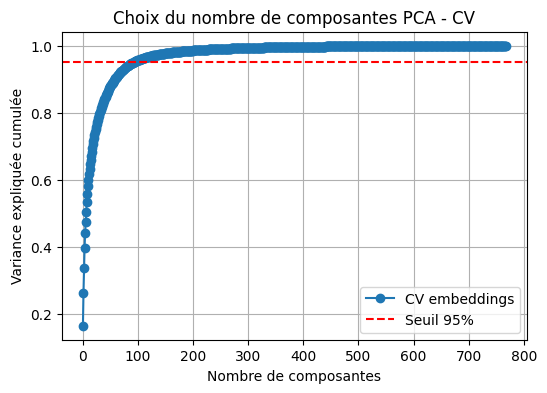

In [ ]:
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === Étape A : CV embeddings ===
pca_cv = PCA()
pca_cv.fit(X_cv_matrix)

explained_var_cv = np.cumsum(pca_cv.explained_variance_ratio_)

# Tracer la courbe pour choisir visuellement le bon nombre
plt.figure(figsize=(6, 4))
plt.plot(explained_var_cv, marker='o', label='CV embeddings')
plt.axhline(y=0.95, color='r', linestyle='--', label='Seuil 95%')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('Choix du nombre de composantes PCA - CV')
plt.legend()
plt.grid(True)
plt.show()
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO



In [ ]:
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
# === Étape 2 : Réduction de dimension avec PCA ===
pca_cv = PCA(n_components=100)
X_cv_reduced = pca_cv.fit_transform(X_cv_matrix)

pca_offre = PCA(n_components=100)
X_offre_reduced = pca_offre.fit_transform(X_offre_matrix)

# === Étape 3 : Concaténer les features supplémentaires ===
X_additional_features = data1[['similarity_score']].values

# Recalcul du score à partir des vecteurs réduits
sim_scores = np.array([
    cosine_similarity([cv], [offre])[0][0]
    for cv, offre in zip(X_cv_reduced, X_offre_reduced)
]).reshape(-1, 1)

# Puis tu concatènes comme ça :
X = np.hstack([X_cv_reduced, X_offre_reduced, sim_scores])
# === Étape 4 : Concaténation des features ===
y = data1['match'].values
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

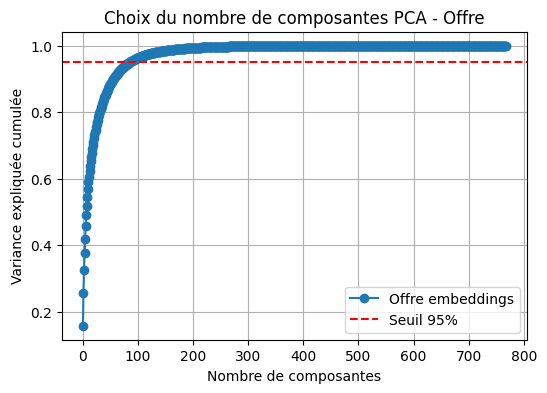

In [ ]:
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
pca_offre = PCA()
pca_offre.fit(X_offre_matrix)

explained_var_offre = np.cumsum(pca_offre.explained_variance_ratio_)

plt.figure(figsize=(6, 4))
plt.plot(explained_var_offre, marker='o', label='Offre embeddings')
plt.axhline(y=0.95, color='r', linestyle='--', label='Seuil 95%')
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('Choix du nombre de composantes PCA - Offre')
plt.legend()
plt.grid(True)
plt.show()
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

In [ ]:
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Recalcul du score à partir des vecteurs réduits
sim_scores = np.array([
    cosine_similarity([cv], [offre])[0][0]
    for cv, offre in zip(X_cv_reduced, X_offre_reduced)
]).reshape(-1, 1)

# Puis tu concatènes comme ça :
X = np.hstack([X_cv_reduced, X_offre_reduced, sim_scores])
# === Étape 4 : Concaténation des features ===
y = data1['match'].values
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
######NOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO

# Application d'une réduction de dimension (PCA à 100 composantes) sur l'ensemble des embeddings, puis concaténation des versions réduites des CV et des offres

In [ ]:
# === Étape 2 : Concaténer tous les embeddings pour entraîner un PCA commun ===
X_all = np.vstack([X_cv_matrix, X_offre_matrix])  # shape (n_cv + n_offre, embedding_dim)

# === Étape 3 : Entraîner le PCA sur tous les embeddings ensemble ===
pca = PCA(n_components=100)
pca.fit(X_all)

# === Étape 4 : Transformer séparément les embeddings CV et Offre avec ce PCA ===
X_cv_reduced = pca.transform(X_cv_matrix)
X_offre_reduced = pca.transform(X_offre_matrix)

# === Étape 5 : Concaténer les embeddings réduits CV + Offre pour former les features ===
X_features = np.hstack([X_cv_reduced, X_offre_reduced])

# On calcule ici une nouvelle similarité cosinus à partir des embeddings réduits par PCA,

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

sim_scores = np.array([
    cosine_similarity([cv], [offre])[0][0]
    for cv, offre in zip(X_cv_reduced, X_offre_reduced)
]).reshape(-1, 1)

# Puis concaténer
X = np.hstack([X_cv_reduced, X_offre_reduced, sim_scores])

In [ ]:
y = data1['match'].values

# On divise les données en un jeu d'entraînement et un jeu de test

In [ ]:
# === Étape 4 : Split train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



678652


# ** Étape 5 : Définir la grille d'hyperparamètres Random Forest **


In [ ]:

# === Étape 6 : Sous-échantillonnage pour le tuning ===
X_tune, y_tune = resample(
    X_train, y_train,
    n_samples=70000,
    random_state=42,
    stratify=y_train
)

In [ ]:
# === Étape 5 : Définir la grille d'hyperparamètres ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced'],
    'max_features': ['sqrt', 'log2']
}


In [ ]:
# === Étape 7 : RandomizedSearchCV sur l'échantillon réduit ===
search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

search.fit(X_tune, y_tune)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced'],
                                        'max_depth': [None, 10, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200]},
                   scoring='accuracy', verbose=1)

In [ ]:

print("Best hyperparameters:", search.best_params_)
print("Best Score (cross-validation):", search.best_score_)

# === Étape 8 : Entraîner le meilleur modèle sur tout le X_train ===


Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}
Best Score (cross-validation): 0.9099857287385632


In [ ]:
best_model = RandomForestClassifier(**search.best_params_, random_state=42)
best_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_split=5,
                       n_estimators=200, random_state=42)

In [ ]:
import joblib

model_path = '/content/drive/MyDrive/camembert/camembert_random_forest_final.joblib'



pca_random_forest = '/content/drive/MyDrive/camembert/pca.joblib'

# Sauvegarde
joblib.dump(pca, pca_random_forest)
joblib.dump(best_model, model_path)


print(f"✅ Modèle ML sauvegardé : {model_path}")




✅ Modèle ML sauvegardé : /content/drive/MyDrive/camembert/camembert_random_forest_final.joblib


In [ ]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    log_loss,
    balanced_accuracy_score,
    cohen_kappa_score
)
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# === Étape 9 : Évaluation sur test ===
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilité classe 1


Accuracy: 0.9497061822554121
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     68888
           1       0.95      0.96      0.96    100775

    accuracy                           0.95    169663
   macro avg       0.95      0.95      0.95    169663
weighted avg       0.95      0.95      0.95    169663




✅ Matrice de confusion:


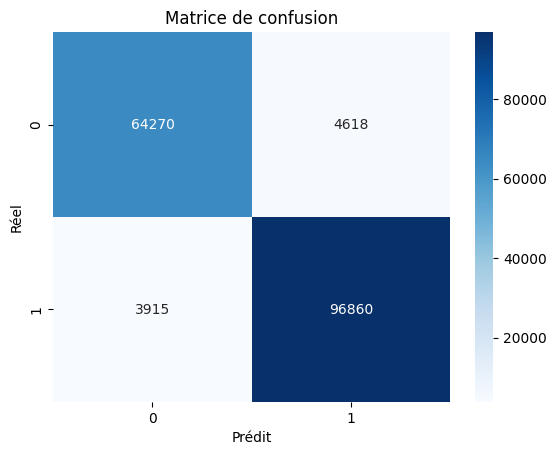

In [ ]:
# 3. Matrice de confusion
print("\n✅ Matrice de confusion:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

In [ ]:
#
auc = roc_auc_score(y_test, y_proba)
print("\n✅ AUC-ROC Score:", auc)


✅ AUC-ROC Score: 0.9916022486973199


In [ ]:
#
print("✅ Log Loss:", log_loss(y_test, y_proba))


✅ Log Loss: 0.1717037552693384


In [ ]:
print("✅ Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))

✅ Balanced Accuracy: 0.9470573651402882


In [ ]:
print("✅ Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))

✅ Cohen's Kappa: 0.8955606280919337


# **Appliquer le model xgboost**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib


In [ ]:
param_dist_xg_boost = {
    "n_estimators": [100, 300, 500],
    "max_depth": [4, 6, 10],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

In [ ]:
search_xgb_boost = RandomizedSearchCV(
    xgb_clf, param_distributions=param_dist_xg_boost,
    n_iter=20, cv=3, scoring="accuracy", verbose=2,
    random_state=42, n_jobs=-1
)

search_xgb_boost.fit(X_tune, y_tune)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [4, 6, 10],
                                        'n_estimators': [100, 300, 500],
                                        'subsample': [0.7, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=2)

In [ ]:
# Entraînement final sur tout le jeu d'entraînement avec meilleurs paramètres
best_xgb = search_xgb_boost.best_estimator_
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# 🔎 Évaluation
y_pred = best_xgb.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("\n=== Accuracy ===")
print(accuracy_score(y_test, y_pred))
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     68888
           1       0.98      0.99      0.98    100775

    accuracy                           0.98    169663
   macro avg       0.98      0.98      0.98    169663
weighted avg       0.98      0.98      0.98    169663


=== Accuracy ===
0.9819642467715413

=== Confusion Matrix ===
[[67124  1764]
 [ 1296 99479]]


In [ ]:
# === Étape 9 : Évaluation sur test ===
y_pred = best_xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
y_proba = best_xgb.predict_proba(X_test)[:, 1]  # Probabilité classe 1

AttributeError: 'str' object has no attribute 'predict'

In [ ]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    log_loss,
    balanced_accuracy_score,
    cohen_kappa_score
)
import matplotlib.pyplot as plt
import seaborn as sns

#
auc = roc_auc_score(y_test, y_proba)
print("\n✅ AUC-ROC Score:", auc)


✅ AUC-ROC Score: 0.9988959088576711


In [ ]:
print("✅ Log Loss:", log_loss(y_test, y_proba))
print("✅ Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("✅ Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))

✅ Log Loss: 0.05113241673654838
✅ Balanced Accuracy: 0.9807664427766449
✅ Cohen's Kappa: 0.9625674661164243


In [ ]:
import joblib

model_path = '/content/drive/MyDrive/camembert/camembert_xgboost_final.joblib'


# Sauvegarde

joblib.dump(best_xgb, model_path)

print(f"✅ Modèle ML sauvegardé : {model_path}")




✅ Modèle ML sauvegardé : /content/drive/MyDrive/camembert/camembert_xgboost_final.joblib


# **Appliquer le model gbm**

In [ ]:
# 📦 Imports
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import joblib



In [ ]:
# 🎯 Entraînement Gradient Boosting avec tuning
param_dist_gbm = {
    "n_estimators": [100, 300, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.7, 0.8, 1.0]
}

gbm = GradientBoostingClassifier(random_state=42)


In [ ]:
search_gbm = RandomizedSearchCV(
    gbm, param_distributions=param_dist_gbm,
    n_iter=20, cv=3, scoring="accuracy", verbose=2,
    random_state=42, n_jobs=-1
)

search_gbm.fit(X_tune, y_tune)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [ ]:
# ✅ Entraînement final sur tout le train avec les meilleurs paramètres
best_gbm = search_gbm.best_estimator_
best_gbm.fit(X_train, y_train)


In [ ]:
# 🔎 Évaluation
y_pred = best_gbm.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("\n=== Accuracy ===")
print(accuracy_score(y_test, y_pred))
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

In [ ]:
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    log_loss,
    balanced_accuracy_score,
    cohen_kappa_score
)
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
#
auc = roc_auc_score(y_test, y_proba)
print("\n✅ AUC-ROC Score:", auc)

In [ ]:
print("✅ Log Loss:", log_loss(y_test, y_proba))
print("✅ Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("✅ Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))

In [ ]:
import joblib

model_path = '/content/drive/MyDrive/camembert/camembert_gbm.joblib'


# Sauvegarde

joblib.dump(best_model, model_path)

print(f"✅ Modèle ML sauvegardé : {model_path}")




# **Appliquer le Naive Bayes**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler



In [ ]:
param_grid_naive = {
    'var_smoothing': np.logspace(0, -9, num=100)  # Le seul hyperparamètre important
}


In [ ]:
# === Étape 7 : RandomizedSearchCV pour Naive Bayes ===
search_naive = RandomizedSearchCV(
    estimator=GaussianNB(),  # Utilisation de Naive Bayes
    param_distributions=param_grid_naive,
    n_iter=20,               # Nombre d'itérations d'échantillonnage
    cv=3,                    # Nombre de folds de validation croisée
    scoring='accuracy',      # Métrique d'évaluation
    n_jobs=-1,               # Utilisation de tous les coeurs CPU
    verbose=1,
    random_state=42
)

search_naive.fit(X_tune, y_tune)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=GaussianNB(), n_iter=20, n_jobs=-1,
                   param_distributions={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
# === Étape 8 : Entraînement final et évaluation ===
best_nb = search_naive.best_estimator_
best_nb.fit(X_train, y_train)

GaussianNB(var_smoothing=np.float64(0.0015199110829529332))

In [ ]:
# 🔎 Évaluation
y_pred = best_nb.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("\n=== Accuracy ===")
print(accuracy_score(y_test, y_pred))
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.84      0.75      0.80     68888
           1       0.84      0.91      0.87    100775

    accuracy                           0.84    169663
   macro avg       0.84      0.83      0.83    169663
weighted avg       0.84      0.84      0.84    169663


=== Accuracy ===
0.8430241125053783

=== Confusion Matrix ===
[[51750 17138]
 [ 9495 91280]]


In [ ]:
#
y_proba = best_nb.predict_proba(X_test)[:, 1]  # Probabilité classe 1
auc = roc_auc_score(y_test, y_proba)
print("\n✅ AUC-ROC Score:", auc)
print("✅ Log Loss:", log_loss(y_test, y_proba))
print("✅ Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("✅ Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))


✅ AUC-ROC Score: 0.9240775870927844
✅ Log Loss: 0.44932073330499894
✅ Balanced Accuracy: 0.8284997869979958
✅ Cohen's Kappa: 0.6687379251145298


In [ ]:
import joblib

model_path = '/content/drive/MyDrive/camembert/camembert_naive_bayes_final.joblib'


# Sauvegarde

joblib.dump(best_nb, model_path)

print(f"✅ Modèle ML sauvegardé : {model_path}")

✅ Modèle ML sauvegardé : /content/drive/MyDrive/camembert/camembert_naive_bayes_final.joblib


# **Appliquer Regression Logistic**

In [ ]:


# === Étape 7 : Définition du modèle et des hyperparamètres ===
logreg = LogisticRegression()

param_grid_lg = [
    # l2 + lbfgs
    {
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'C': uniform(0.01, 10),
        'max_iter': [100, 200, 500]
    },
    # l1 + saga
    {
        'penalty': ['l1'],
        'solver': ['saga'],
        'C': uniform(0.01, 10),
        'max_iter': [100, 200, 500]
    },
    # l2 + saga
    {
        'penalty': ['l2'],
        'solver': ['saga'],
        'C': uniform(0.01, 10),
        'max_iter': [100, 200, 500]
    },
    # elasticnet + saga (avec l1_ratio obligatoire)
    {
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'C': uniform(0.01, 10),
        'l1_ratio': uniform(0, 1),
        'max_iter': [100, 200, 500]
    },
    # aucun penalty (sans régularisation)
    {
        'penalty': [None],
        'solver': ['lbfgs'],
        'max_iter': [100, 200, 500]
    }
]

# === Étape 8 : RandomizedSearchCV ===
search_lg = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_grid_lg,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# === Étape 9 : Recherche des meilleurs hyperparamètres ===
search_lg.fit(X_tune, y_tune)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=20, n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7dbf887b7b10>,
                                         'max_iter': [100, 200, 500],
                                         'penalty': ['l2'],
                                         'solver': ['lbfgs']},
                                        {'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7dbf887b6690>,
                                         'max_iter': [100, 200, 500]...
                                        {'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7dbf887b4450>,
                                         'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7dbf887b5550>,
                                         'max_iter': [100, 200, 500],
                                         'penalty': ['elasticnet'],
                                         'solver': ['saga']},
                                        {'max_iter': [100, 200, 500],
                                         'penalty': [None],
                                         'solver': ['lbfgs']}],
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
# === Étape 10 : Entraîner le meilleur modèle sur tout le train set ===
best_model_lg = LogisticRegression(**search_lg.best_params_)
best_model_lg.fit(X_train, y_train)

LogisticRegression(C=np.float64(0.4766566321361543), max_iter=500, penalty='l1',
                   solver='saga')

In [ ]:
best_model_lg = search_lg.best_estimator_
best_model_lg.fit(X_train, y_train)

LogisticRegression(C=np.float64(0.4766566321361543), max_iter=500, penalty='l1',
                   solver='saga')

In [ ]:
# 🔎 Évaluation
y_pred = best_model_lg.predict(X_test)
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))
print("\n=== Accuracy ===")
print(accuracy_score(y_test, y_pred))
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     68888
           1       0.91      0.92      0.91    100775

    accuracy                           0.89    169663
   macro avg       0.89      0.89      0.89    169663
weighted avg       0.89      0.89      0.89    169663


=== Accuracy ===
0.894673558760602

=== Confusion Matrix ===
[[59237  9651]
 [ 8219 92556]]


In [ ]:
#
y_proba = best_nb.predict_proba(X_test)[:, 1]  # Probabilité classe 1
auc = roc_auc_score(y_test, y_proba)
print("\n✅ AUC-ROC Score:", auc)
print("✅ Log Loss:", log_loss(y_test, y_proba))
print("✅ Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("✅ Cohen's Kappa:", cohen_kappa_score(y_test, y_pred))


✅ AUC-ROC Score: 0.5
✅ Log Loss: 21.408905714789206
✅ Balanced Accuracy: 0.8891725524669585
✅ Cohen's Kappa: 0.7809133303371051


In [ ]:
import joblib
import joblib

model_path = '/content/drive/MyDrive/camembert/camembert_lg.joblib'

scaler_cv_path="/content/drive/MyDrive/camembert/scaler_cv.joblib"
scaler_offre_path="/content/drive/MyDrive/camembert/scaler_offre.joblib"

pca_cv_path="/content/drive/MyDrive/camembert/pca_cv_std.joblib"
pca_offre_path="/content/drive/MyDrive/camembert/pca_offre_std.joblib"

# Sauvegarde

joblib.dump(best_model_lg, model_path)

print(f"✅ Modèle ML sauvegardé : {model_path}")

# Sauvegarder les scalers
joblib.dump(scaler_cv, scaler_cv_path)
joblib.dump(scaler_offre, scaler_offre_path)

# Sauvegarder les PCA
joblib.dump(pca_cv, pca_cv_path)
joblib.dump(pca_offre, pca_offre_path)

✅ Modèle ML sauvegardé : /content/drive/MyDrive/camembert/camembert_lg.joblib


['/content/drive/MyDrive/camembert/pca_offre_std.joblib']

# **Testing**

# **Tester camembert + random Forest**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from sentence_transformers import SentenceTransformer
import numpy as np
import joblib
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Télécharger les ressources NLTK nécessaires (une fois)
nltk.download('punkt_tab')
nltk.download('stopwords')


# Charger les modèles sauvegardés

path_model = "drive/MyDrive/camembert/tsdae-camemebert-4"
#path_model ="drive/MyDrive/tsdae-model-5-final"
best_xgb =joblib.load("/content/drive/MyDrive/camembert/camembert_xgboost_final.joblib")
best_nv =joblib.load("/content/drive/MyDrive/camembert/camembert_naive_bayes_final.joblib")

model = SentenceTransformer(path_model)
pca = joblib.load('/content/drive/MyDrive/camembert/pca.joblib')
rf_model = joblib.load('/content/drive/MyDrive/camembert/camembert_random_forest_final.joblib')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
 #Nettoyage + tokenisation avec NLTK
def preprocess_text(text):
    # Passage en minuscules
    text = text.lower()
    # Tokenisation
    tokens = word_tokenize(text)
    # Enlever la ponctuation et les stopwords
    stop_words = set(stopwords.words('french'))
    tokens = [t for t in tokens if t not in stop_words and t not in string.punctuation]
    # Reconstruction de la phrase nettoyée
    return " ".join(tokens)

In [5]:
# Exemple réel : CV complet (informatique)
cv_text = """
Développeur Python avec 4 ans d’expérience en data engineering.
Compétent en automatisation de pipelines de données avec Pandas, NumPy, et utilisation d’APIs tierces.
Expérience sur des projets de collecte et transformation de données pour la BI.
Maîtrise de Git, familiarité avec AWS (EC2, S3) et déploiement de scripts Python en production.
Disponible immédiatement, basé à Paris.
"""

# Exemple réel : Offre d’emploi complète (informatique)
offre_text = """
Offre d’emploi : Développeur Python (H/F)
Nous recherchons un développeur Python pour rejoindre notre équipe data.
Vous participerez à l’automatisation de traitements de données, à l’intégration d’APIs REST, et au développement de scripts pour la plateforme interne.
Une bonne maîtrise de Pandas, NumPy, ainsi qu’une connaissance des outils de versioning (Git) est exigée.
Une expérience en cloud (AWS ou GCP) est un plus.
Poste basé à Paris, en hybride, CDI.
"""





In [ ]:
# Exemple réel : CV complet (informatique)
cv_text = """
developpeur python
"""

# Exemple réel : Offre d’emploi complète (informatique)
offre_text = """
developpeur python
"""

In [6]:
# Nettoyer et tokeniser les textes
cv_clean = preprocess_text(cv_text)
offre_clean = preprocess_text(offre_text)

cv_clean = cv_text
offre_clean = offre_text
print("CV nettoyé :", cv_clean)
print("Offre nettoyée :", offre_clean)

CV nettoyé : 
Développeur Python avec 4 ans d’expérience en data engineering.
Compétent en automatisation de pipelines de données avec Pandas, NumPy, et utilisation d’APIs tierces.
Expérience sur des projets de collecte et transformation de données pour la BI.
Maîtrise de Git, familiarité avec AWS (EC2, S3) et déploiement de scripts Python en production.
Disponible immédiatement, basé à Paris.

Offre nettoyée : 
Offre d’emploi : Développeur Python (H/F)
Nous recherchons un développeur Python pour rejoindre notre équipe data.
Vous participerez à l’automatisation de traitements de données, à l’intégration d’APIs REST, et au développement de scripts pour la plateforme interne.
Une bonne maîtrise de Pandas, NumPy, ainsi qu’une connaissance des outils de versioning (Git) est exigée.
Une expérience en cloud (AWS ou GCP) est un plus.
Poste basé à Paris, en hybride, CDI.



In [7]:
cv_emb = model.encode(cv_clean, convert_to_numpy=True).reshape(1, -1)
offre_emb = model.encode(offre_clean, convert_to_numpy=True).reshape(1, -1)


In [8]:
cv_emb_reduced = pca.transform(cv_emb)       # input shape (1, 768)
offre_emb_reduced = pca.transform(offre_emb) # input shape (1, 768)

X_concat_reduced = np.hstack([cv_emb_reduced, offre_emb_reduced])

In [9]:
# 9. Calculer similarité cosinus sur embeddings d'origine (768 dim)
sim_score_original = cosine_similarity(cv_emb, offre_emb)[0][0]

In [10]:
sim_score_reduced = cosine_similarity(cv_emb_reduced, offre_emb_reduced)[0][0]


In [11]:
# 11. Affichage résultats
print(f"Similarité embeddings originaux : {sim_score_original:.4f}")
print(f"Similarité embeddings après PCA : {sim_score_reduced:.4f}")

Similarité embeddings originaux : 0.8680
Similarité embeddings après PCA : 0.5906


In [28]:
X_test = np.hstack([X_concat_reduced, [[sim_score_original]]])


In [29]:
# --- Prédiction RF ---
pred = rf_model.predict(X_test)[0]
proba = rf_model.predict_proba(X_test)[0]
print(f"Score similarité avant PCA : {sim_score_original:.4f}")
print(f"Prédiction match (1=match, 0=no match) : {pred}")
print(f"Probabilités : {proba}")

Score similarité avant PCA : 0.8680
Prédiction match (1=match, 0=no match) : 1
Probabilités : [0.4809326 0.5190674]


# **Appliquer xgboost**

In [30]:
# --- Prédiction RF ---
pred = best_xgb.predict(X_test)[0]
proba = best_xgb.predict_proba(X_test)[0]
print(f"Score similarité avant PCA : {sim_score_original:.4f}")
print(f"Prédiction match (1=match, 0=no match) : {pred}")
print(f"Probabilités : {proba}")

Score similarité avant PCA : 0.8680
Prédiction match (1=match, 0=no match) : 0
Probabilités : [0.9418601  0.05813995]


# **Appliquer Naive Bayes**

In [31]:
# --- Prédiction RF ---
pred = best_nv.predict(X_test)[0]
proba = best_nv.predict_proba(X_test)[0]
print(f"Score similarité avant PCA : {sim_score_original:.4f}")
print(f"Prédiction match (1=match, 0=no match) : {pred}")
print(f"Probabilités : {proba}")

Score similarité avant PCA : 0.8680
Prédiction match (1=match, 0=no match) : 0
Probabilités : [0.99872433 0.00127567]
